# Predicting house prices in California

This is a structured data project whose objective is to predict the median price of houses in a district given some attributes of the house, such as number of rooms, bedrooms and proximity to the ocean. I started this project by following the book *Hands-On Machine Learning with Scikit-Learn and TensorFlow* by Aurélien Geron. Initially, I went through the data *as is*. Afterwards, I went into performing some feature engineering, where I included extra attributes, such as the proximity of the house to a city and big city centers (https://www.kaggle.com/camnugent/california-housing-prices/downloads/housing.csv/1#Introduction-and-goals)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
import tarfile
import pandas as pd
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from six.moves import urllib
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

from mllib import *

In [ ]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("STD: ", scores.std())

In [3]:
data = load_data(data_name="housing.csv", data_path='/home/alexandre/Dropbox/ml/ml1/mllib/housing-california/')

We will start by importing the raw data and making some very basic data visualization:

In [4]:
housing = MLDataset(data_frame=data)

Data frame dimensions: (20640, 10)


Features available: 

longitude	
latitude	
housing_median_age	
total_rooms	
total_bedrooms	
population	
households	
median_income	
median_house_value	
ocean_proximity	


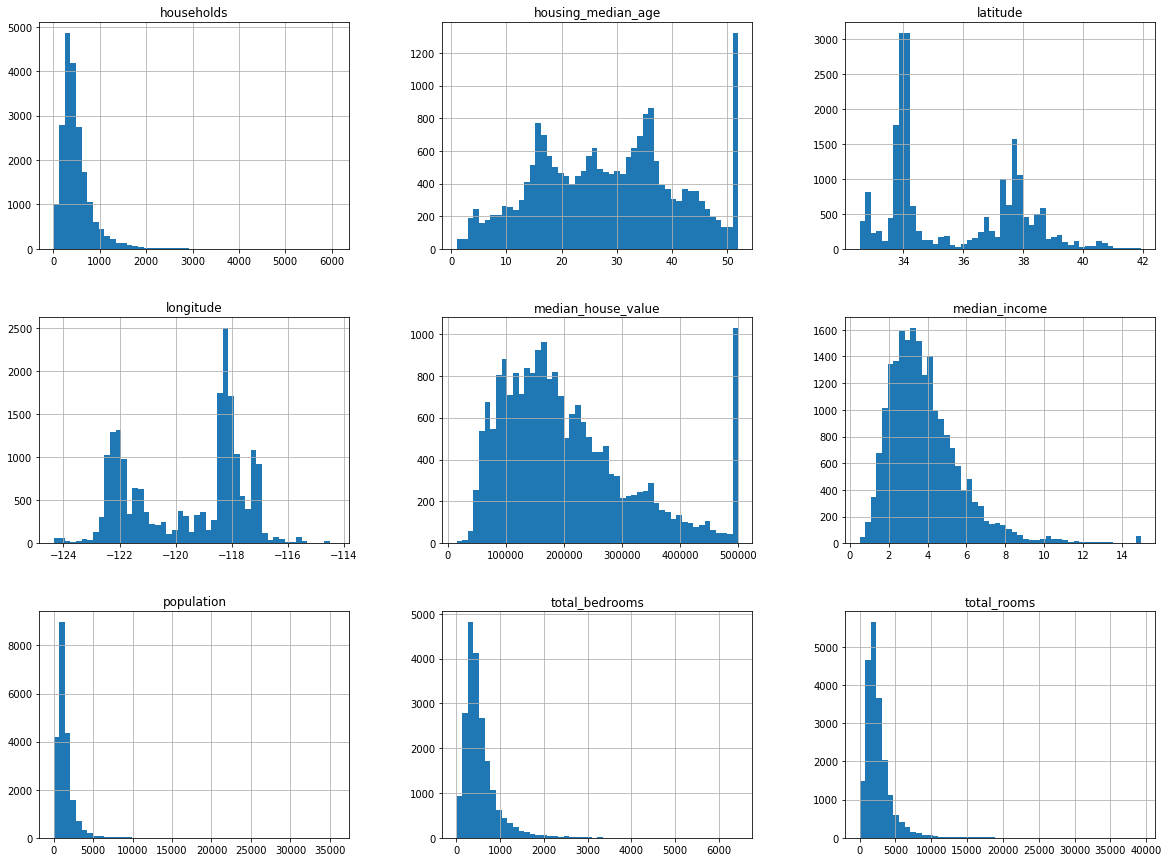

In [5]:
housing.plot_hist()

These distributions are all over the place. Very simplistic models won't help me much. But let's proceed to an important detail: the data involves geolocations. Plotting it against our target can be interesting to give us some insight of our data based on our geographic knowledge: 

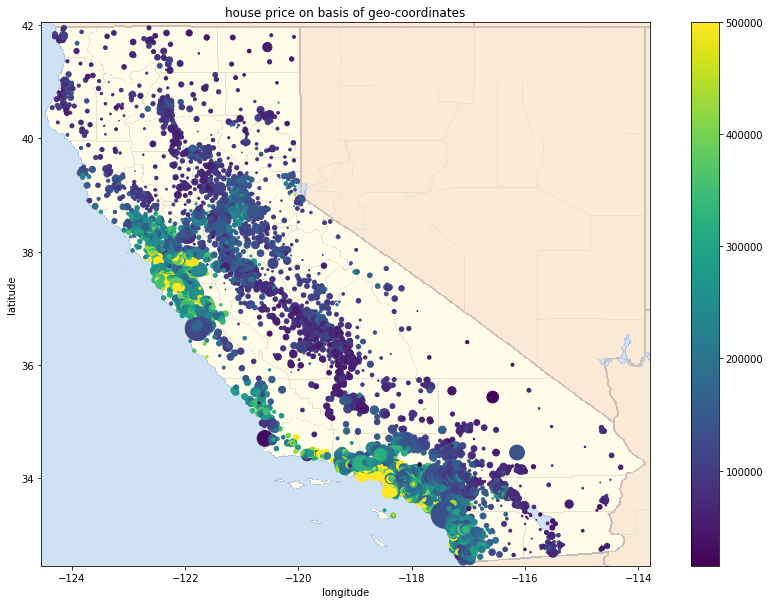

In [6]:
california_img=mpimg.imread('./california.png')

plt.figure(figsize=(15,10))
plt.scatter(housing._dataset['longitude'],housing._dataset['latitude'],
            c=housing._dataset['median_house_value'],s=housing._dataset['population']/50,cmap='viridis')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.title('house price on basis of geo-coordinates')
plt.show()

So there is a big density of expensive houses in regions around big cities: San Francisco, Los Angeles and San Diego. Cheaper houses are scattered in the countryside of the state, particularly away from these big city centers. Let's keep all this information in mind for some future feature engineering.

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


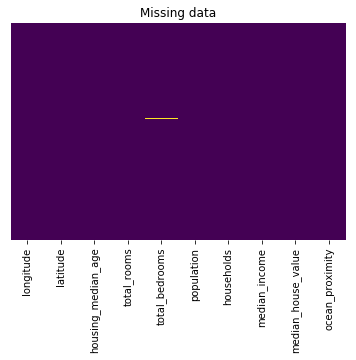

In [7]:
housing.check_empty_data()

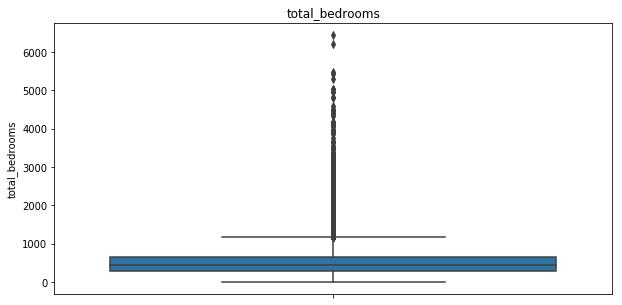

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64


In [8]:
housing.check_feat(feature='total_bedrooms')

There is data missing: *total_bedrooms*. We need to fill this up. Notice that this attribute has a distribution very skewed. A reasonable option is to use the median of the data to fill the gaps. This is a way of putting data in that won't be biased.

In [9]:
housing.fill_gaps(feature='total_bedrooms', strategy='median')

Filling gaps with median


Since we have a categorical variable here, it's worth having an eye into its features, as it can tell us something. I plot it againts our labels, as it can give me interesting insights:

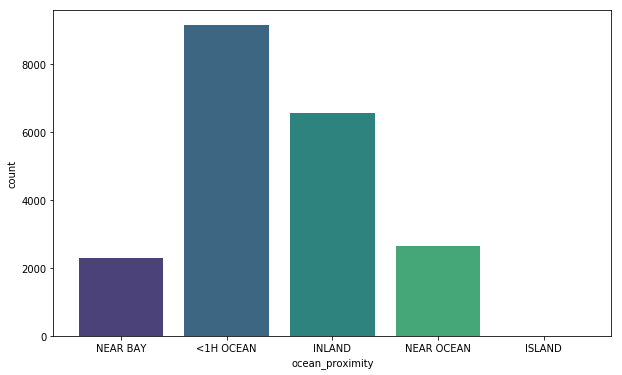

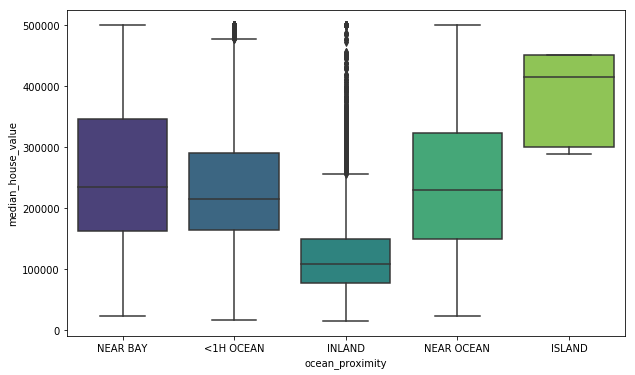

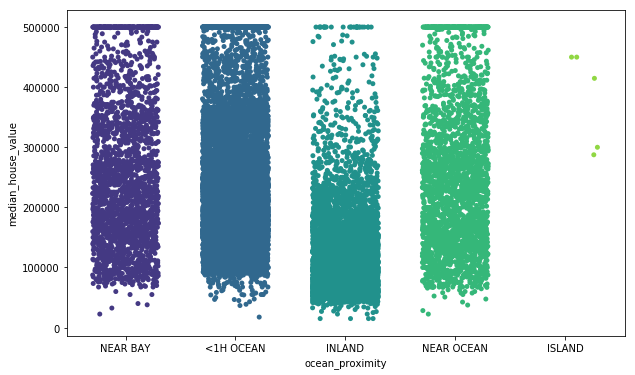

In [10]:
housing.check_cat_feat(cat_feat='ocean_proximity', label='median_house_value')

Finally, is there any linear correlation between features? Let's take a look:

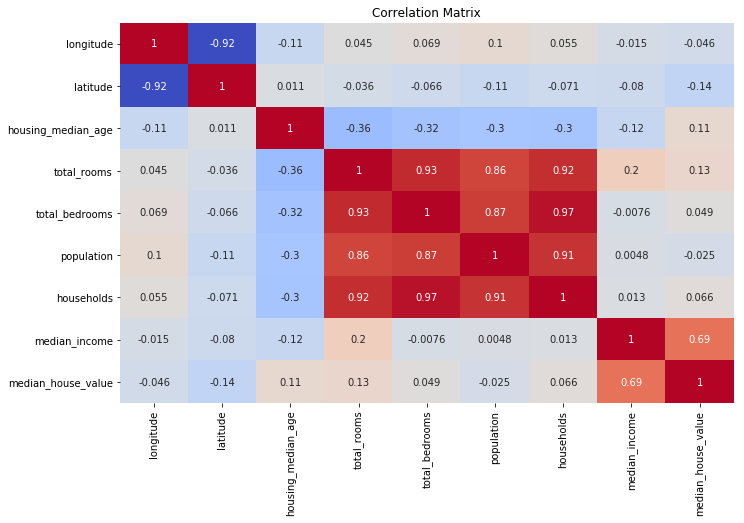

In [11]:
housing.plot_corr_mat()

The correlation matrix shows that some variables can be highly correlated to others. Therefore, models like Naive Bayes might not be properly used here.

Now it's time to prepare the data to start making some deeper analysis. I will first split the data into train and test sets. The split of data will be stratified, so that I ensure that my training and test sets are statistically similar, preventing any overfitting on features in the training set that are not present in the test. I used *median_income* as my stratification parameter, and will separate the data in five groups of income. I will also make sure that I tell what will be my labels, so they are separated from my training and testing data. Finally, I am distinguishing between categorical and numerical data, and passing everything through a pipeline that will get my data good to go:

In [12]:
housing.strat_train_test_split(attrib="median_income", num_strat=5, drop=True)
housing.get_labels("median_house_value")
housing.set_attrib_types("ocean_proximity")

pipeline = housing.set_pipeline()

housing_prepared = pipeline.fit_transform(housing._strattrain)
housing_test_prepared = pipeline.fit_transform(housing._strattest)
housing_labels = housing._labelstrain

OK, data is now ready. As a first analysis, I will perform PCA to see where most of the variance of my data is coming from. It could tell me about features that matter, and even those that could be irrelevant:

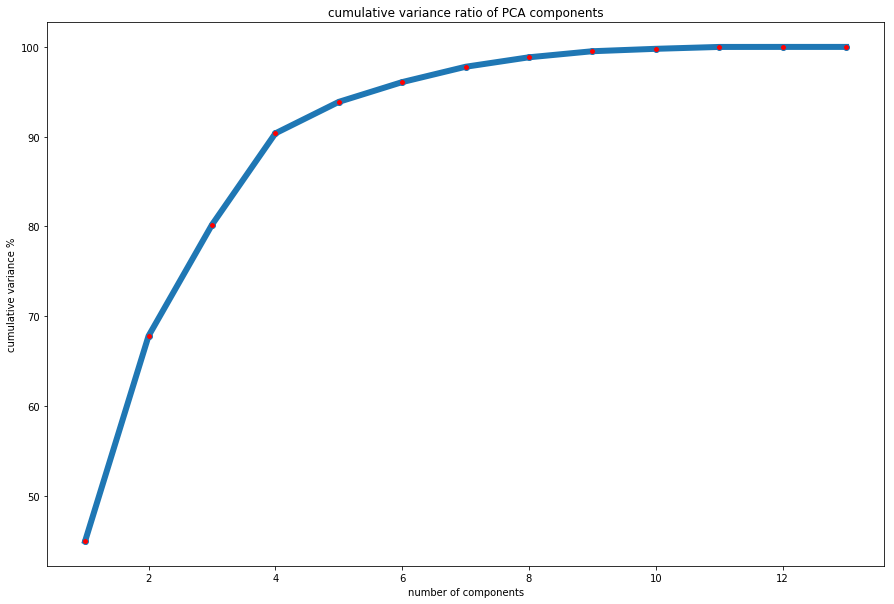

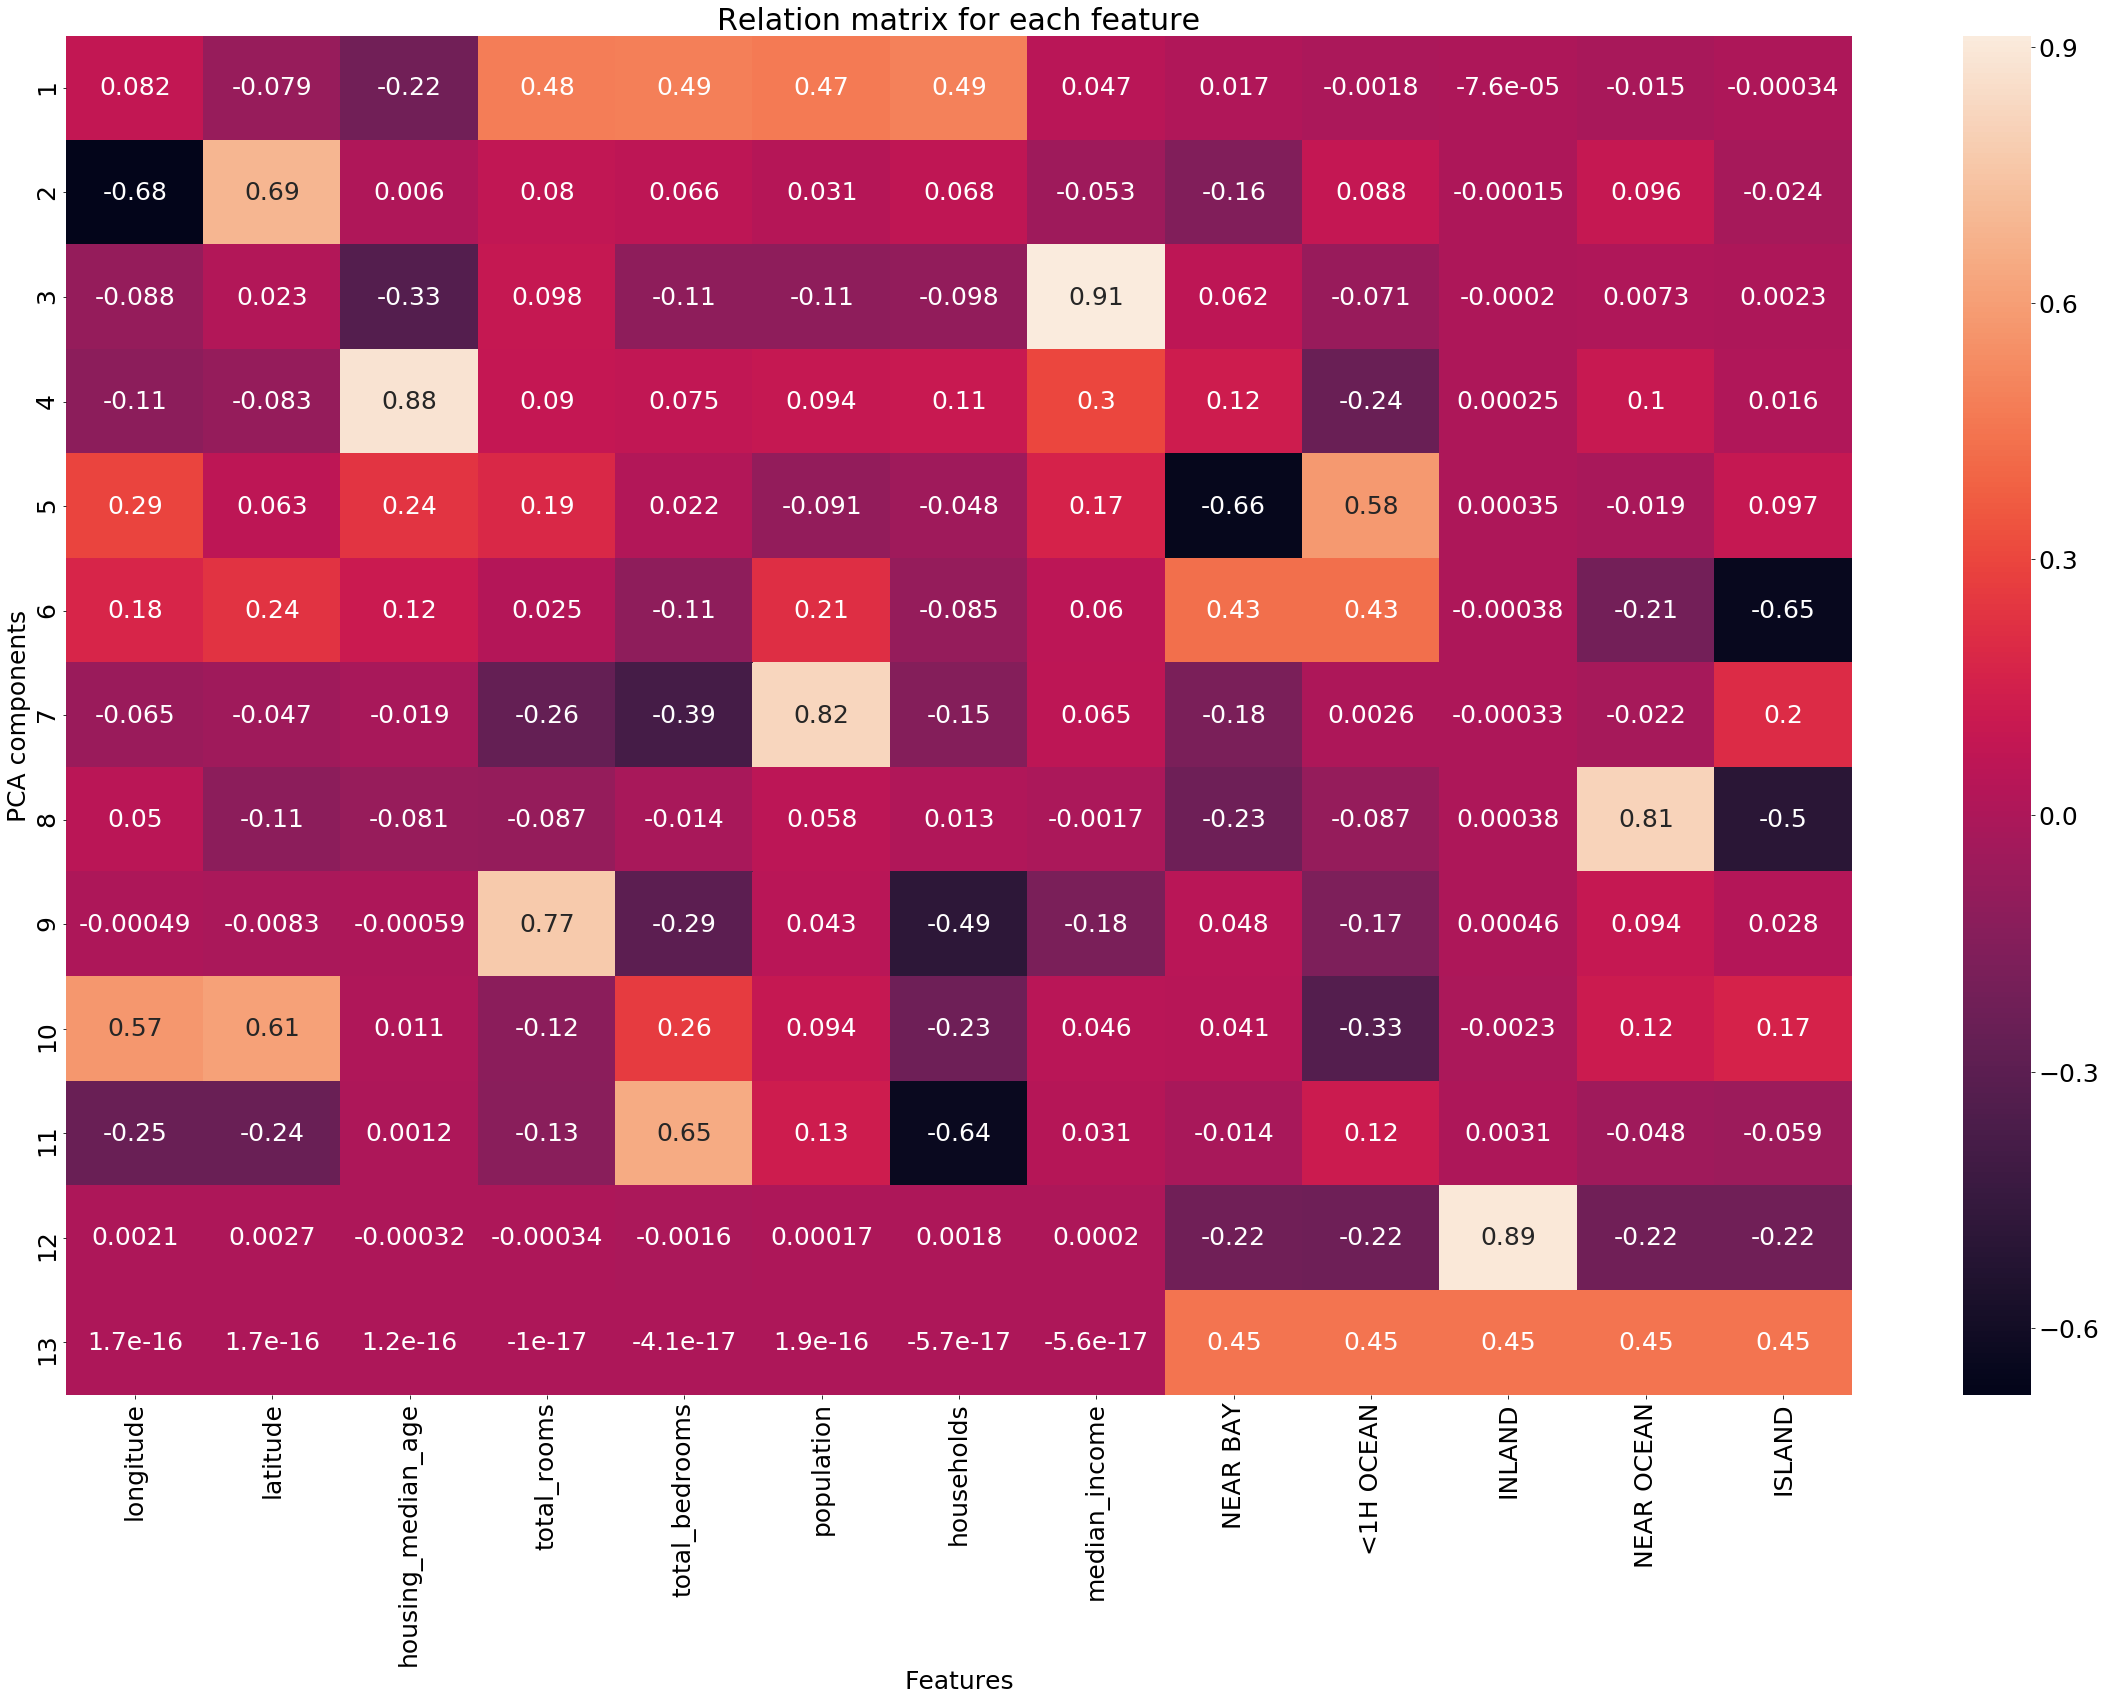

In [13]:
housing.plot_pca(housing_prepared)

So the first component is a strong mix between total_rooms, total_bedrooms, population and households. This makes sense: the bigger the house, the more rooms, and therefore, the higher the cost. Moreover, higher population means being at a densely populated area, *i.e.* a city. The second component relates latitude and longitude, which are important, as the Southern California area particularly amasses the highest amount of mansions, and houses by the beach. So overall, the PCA gave us a quantitative measure of common sense knowledge on real estate market.

## Training and evaluating on training set

Let us start training simple models to see what sort of prediction we can make. I generally start with a simple model, to have a feel about the data. So let's do like Aurélien and start with a linear regression. To quantify how much error we have, Scikit-Learn has a set of metrics for error functions. For instance, let us check the root mean square error:

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68447.29787331671

This means that we are having errors of over \$68,000, which is bad for houses whose *median_housing_value* range are lower than \$300,000. Obviously, linear regression is too simple of a model. Let's go for something more sophisticated:

In [25]:
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("STD: ", scores.std())
    
display_scores(tree_rmse_scores)

Scores:  [59546.57035937 69492.17932585 64244.6624577  66823.63832905
 67383.78150729 63236.43935313 60278.28671733 64957.35159056
 65414.04698985 65955.87979388]
Mean:  64733.28364240109
STD:  2920.247970209779


It seems like the error is even worse than the Linear Regression model. We can certify that by performing the same K-fold cross-validation with the linear regression model:

In [39]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


21736.918534383156

In [40]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores:  [48409.82027953 53125.8150423  49725.55798628 51723.97561029
 48032.68200083 48270.24456241 49833.59595823 53377.97979472
 50935.63614538 54557.82609355]
Mean:  50799.31334735181
STD:  2211.51099367077


The results have improved significantly. However, notice how the model overfits. When dealing with overfitting, we need to either simplify the model, acquire more data, or regularize the model. There are plenty of other Machine Learning techniques that we could try. Before going further into those, let's go through some ideas on how to fine-tune a model.

## Fine-tuning a model

### Grid Search

Fine-tuning a model requires fiddling with several parameters. This can be done manually, although it can be a tedious task. There are other techniques implemented on Scikit-Learn that makes the task automatic and more systematic. One of them is *Grid Search*. The GridSearch has several hyperparameters that can be tuned. When setting the parameters for GridSearch, we often have two sets of numbers: *n_estimators* and *max_features*. Those will be combined for the fine-tuning. The *n_estimators* can be set either as powers of 10 or 3 we have no idea where to start from. In the case below, we will have two groups of these two sets. The first one performs bootstrap sampling, and in the second case this options is turned off. Let us apply this technique on our Random Forest model:

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30],
               'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False],
               'n_estimators': [3, 10],
               'max_features': [2, 3, 4]}]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Once the Grid Search is over, we can check which parameters yielded the smallest error. From there, we can go further and choose to either perform additional Grid Search.

In [45]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [46]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63411.79279552775 {'max_features': 2, 'n_estimators': 3}
54372.41343901001 {'max_features': 2, 'n_estimators': 10}
52099.832151557435 {'max_features': 2, 'n_estimators': 30}
59488.24739951718 {'max_features': 4, 'n_estimators': 3}
52594.34897389675 {'max_features': 4, 'n_estimators': 10}
50043.0383244721 {'max_features': 4, 'n_estimators': 30}
59229.57815938876 {'max_features': 6, 'n_estimators': 3}
51852.568710888656 {'max_features': 6, 'n_estimators': 10}
49556.4566083071 {'max_features': 6, 'n_estimators': 30}
57832.69750375408 {'max_features': 8, 'n_estimators': 3}
51435.62878906022 {'max_features': 8, 'n_estimators': 10}
49819.86436010661 {'max_features': 8, 'n_estimators': 30}
61898.15945753975 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53446.14095099518 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59616.00809724038 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52501.28290231281 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [47]:
housing.get_feat_import(grid_search=grid_search)

[(0.41262383404559966, 'median_income'),
 (0.1499939537899569, 'INLAND'),
 (0.11630023094911889, 'longitude'),
 (0.11218630863275728, 'latitude'),
 (0.046231547958172636, 'housing_median_age'),
 (0.04352071044353324, 'population'),
 (0.03549617958270565, 'total_rooms'),
 (0.028042607460192236, 'total_bedrooms'),
 (0.026242489727805844, 'households'),
 (0.016377024816123062, '<1H OCEAN'),
 (0.006832040131577111, 'NEAR OCEAN'),
 (0.006030938474383189, 'NEAR BAY'),
 (0.00012213398807447344, 'ISLAND')]

In [48]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(housing_test_prepared)

final_mse = mean_squared_error(housing._labelstest, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

55443.73148350647

From \\$68,000 to \$55,000 is surely a big improvement. There are other ML algorithms we could try, such as SVM and Kernel Ridge regressors. Let's try:

In [49]:
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-1, 1, 3)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-1, 1, 3)})

In [50]:
svr.fit(housing_prepared, housing_labels)
svr.best_params_

{'C': 1000.0, 'gamma': 0.1}

In [45]:
cvres = svr.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.22120264089527394 {'C': 1.0, 'gamma': 0.1}
0.23115879726786245 {'C': 1.0, 'gamma': 1.0}
0.23318423692154794 {'C': 1.0, 'gamma': 10.0}
0.055316815650520317 {'C': 10.0, 'gamma': 0.1}
0.21115058998055877 {'C': 10.0, 'gamma': 1.0}
0.23270371071443635 {'C': 10.0, 'gamma': 10.0}
nan {'C': 100.0, 'gamma': 0.1}
nan {'C': 100.0, 'gamma': 1.0}
0.22717263110695002 {'C': 100.0, 'gamma': 10.0}
nan {'C': 1000.0, 'gamma': 0.1}
nan {'C': 1000.0, 'gamma': 1.0}
0.171786190521843 {'C': 1000.0, 'gamma': 10.0}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [51]:
housing_predictions = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

69103.59113148719

In [52]:
kr.fit(housing_prepared, housing_labels)
kr.best_params_

{'alpha': 0.01, 'gamma': 0.1}

In [53]:
housing_predictions = kr.predict(housing_prepared)
kr_mse = mean_squared_error(housing_labels, housing_predictions)
kr_rmse = np.sqrt(kr_mse)
kr_rmse

47243.00322273041

Kernel Ridge regression gave an impressive result, reducing the RMSE from \\$55,000 further down to \$47,000. I could continue on exploring more parameters of it, and even trying other approaches. But let's try something else: adding more information. Remember the plot of house prices in terms of the position? What if I add information regarding the location of each house district with regards to the closest municipality, and the closest big city? I will start performing some Feature Engineering.

# Feature Engineering

A kaggle user did some neat work of geospatial feature engineering (https://www.kaggle.com/camnugent/california-housing-prices/downloads/housing.csv/1#Introduction-and-goals). Three CSV files were uploaded, containing information of cities in CA, in terms of position, population per city, and per county.

In [10]:
city_lat_long = pd.read_csv('cal_cities_lat_long.csv')
city_pop_data = pd.read_csv('cal_populations_city.csv')
county_pop_data = pd.read_csv('cal_populations_county.csv')

To start with, we will calculate the distance between each house district and the closest city. For that, we will use **geopy.distance vincenty**. This function accepts two tuples as arguments, each tuple made of latitude and longitude, in that order. Thus, to begin with, let's build a dictionary containing every city and the coordinates of their centers:

In [11]:
city_coords = {}

for city in city_lat_long.iterrows():
    row = city[1]
    if row['Name'] not in city_pop_data['City'].values:   
        continue           
    else: 
        city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))

In [12]:
from geopy.distance import vincenty

def closest_point(location, location_dict):
    """ take a tuple of latitude and longitude and 
        compare to a dictonary of locations where
        key = location name and value = (lat, long)
        returns tuple of (closest_location , distance) """
    closest_location = None
    for city in location_dict.keys():
        distance = vincenty(location, location_dict[city]).kilometers
        if closest_location is None:
            closest_location = (city, distance)
        elif distance < closest_location[1]:
            closest_location = (city, distance)
    return closest_location

In [13]:
test = (39.524325, -122.293592) #likely 'Willows'
closest_point(test, city_coords)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


('Willows', 8.598342477208991)

The next bit of code builds a dictonary of (city, population) (key, value) pairs and then goes through and builds a separate coordinate dictonary for only the big cities.

We use the April 1990 population data below, as the housing price information that we are trying to model is based off of the 1990 California Census.


In [14]:
city_pop_dict = {}

for city in city_pop_data.iterrows():
    row = city[1]
    city_pop_dict[row['City']] =  row['pop_april_1990']


big_cities = {}

for key, value in city_coords.items():
    if city_pop_dict[key] > 500000:
        big_cities[key] = value

The dictonaries and functions we created are then applied to the main housing dataframe to make the new data columns. This is done mainly using the pandas .apply() function.

In [15]:
#######
# adding closest city data to dataframes
#######

housing.df['close_city'] = housing.df.apply(lambda x: closest_point((x['latitude'],x['longitude']),city_coords), axis = 1)
housing.df['close_city_name'] = [x[0] for x in housing.df['close_city'].values]
housing.df['close_city_dist'] = [x[1] for x in housing.df['close_city'].values]
housing.df['close_city_pop'] = [city_pop_dict[x] for x in housing.df['close_city_name'].values]

housing.df = housing.df.drop('close_city', axis=1)

#add the data relating to the points to the closest big city
housing.df['big_city'] = housing.df.apply(lambda x: closest_point((x['latitude'],x['longitude']),big_cities), axis = 1)
housing.df['big_city_name'] = [x[0] for x in housing.df['big_city'].values]
housing.df['big_city_dist'] = [x[1] for x in housing.df['big_city'].values]

housing.df = housing.df.drop('big_city', axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


Let's expand on the visualization of data now that there are more things to see. For instance, it would be interesting to see how each district is connect to each closest city and big city:

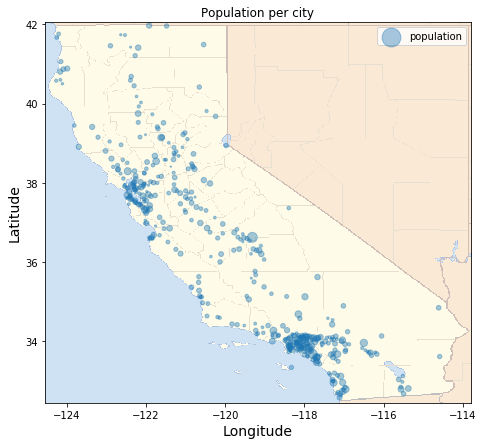

In [24]:
housing_plot = housing.df[['longitude','population','latitude', 'close_city_name','big_city_name','big_city_dist','median_house_value']]

city_lat_long['Population'] = [city_pop_dict[x] if x in city_pop_dict.keys() 
                               else 0 for x in city_lat_long['Name'].values]
# graph of the location of the cities and their size
city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
                   s=housing_plot['population']/50, label='population', figsize=(10,7))

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Population per city')
plt.legend() 
plt.show()

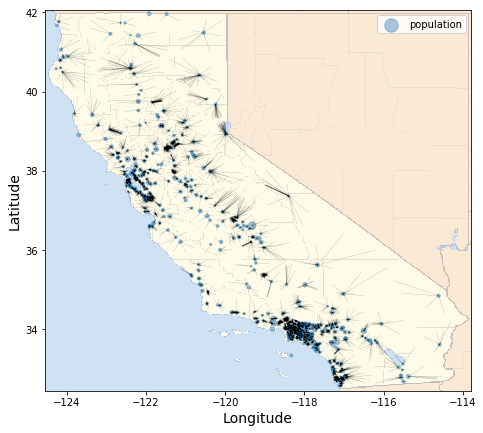

In [25]:
####
# graph of vectors connecting points to their nearest city

city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude', 
                   alpha=0.4, s=housing_plot['population']/100, 
                   label='population', figsize=(10,7))

for line in housing.df.iterrows():
    dat = line[1]
    x1 = dat['longitude']
    y1 = dat['latitude']
    p2 = city_coords[dat['close_city_name']]
    x2 = p2[1]
    y2 = p2[0]
    plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.1)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Connection between housing districts and cities')
plt.show()

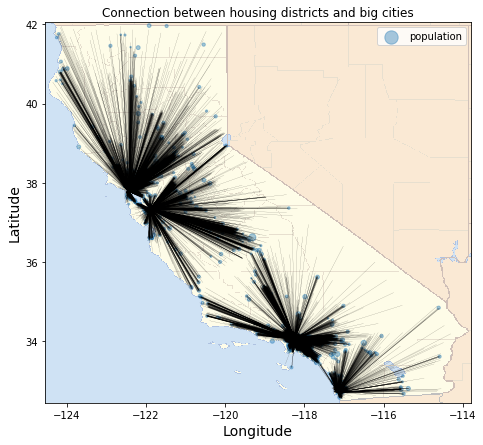

In [26]:
####
# graph of the vectors connecting districts to the nearest major city
# and a barplot of distance to the nearest major city

city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude', 
                   alpha=0.4, s=housing_plot['population']/100, 
                   label='population', figsize=(10,7))

for line in housing.df.iterrows():
    dat = line[1]
    x1 = dat['longitude']
    y1 = dat['latitude']
    p2 = big_cities[dat['big_city_name']]
    x2 = p2[1]
    y2 = p2[0]
    plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.1)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Connection between housing districts and big cities")
plt.show()

Now it's time to prepare the data again. Since I got extra categorical attributes, I need to make sure those are set as categorical before passing them through my pipeline. 

In [16]:
housing.strat_train_test_split(attrib="median_income", num_strat=5, drop=True)
housing.get_labels("median_house_value")
housing.set_attrib_types(cat_attribs=["ocean_proximity","close_city_name","big_city_name"])

pipeline = housing.set_pipeline()

housing_prepared = pipeline.fit_transform(housing._strattrain)
housing_test_prepared = pipeline.transform(housing._strattest)
housing_labels = housing._labelstrain
housing_test_labels = housing._labelstest

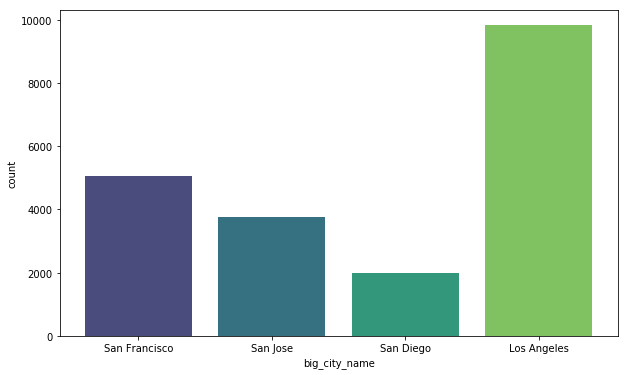

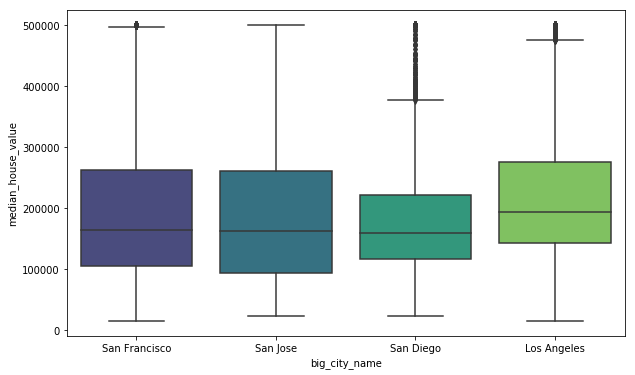

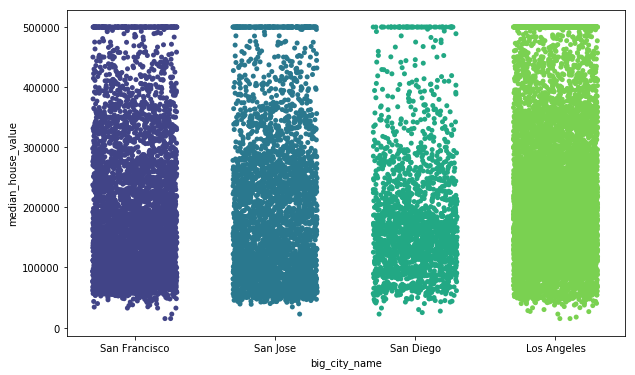

In [20]:
housing.check_cat_feat(cat_feat="big_city_name", label='median_house_value')

Let's make some of the tests done before, starting with a simple linear regression:

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

52084.73388282077

This is a massive improvement: from \\$68,000 to \$52,000, just with feature engineering! Let's perform cross-validation just to make sure everything is fine:

In [28]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores:  [5.15648110e+04 5.59419263e+04 5.37312040e+04 5.61987106e+04
 2.74880029e+13 8.44369327e+12 5.46436253e+04 5.22925629e+04
 5.35619607e+04 5.41119347e+04]
Mean:  3593169656720.9287
STD:  8353308180842.339


So there seems to be an issue, where two folds yield some crazy results. Still, the other folds match the significant improvement with feature engineering. Let's check now Random Forest:

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores:  [46003.103478   52743.68593748 49138.5178389  51199.54648318
 49742.17309987 47854.7321378  48328.15983055 49780.39566325
 49728.23247095 51143.21757108]
Mean:  49566.1764511049
STD:  1808.1691687218713


When compared to the previous time, the improvement here was of only 2%. The standard deviation is lower, which can be interpreted as a more resilient model, although in terms of scale of the RMSE, it's not very significant. So it was a mere coincidence in the case of the Linear Regressor. Still, an improvement is an improvement, and it could point out to the fact that the system could have become more linear. Let's get our best predictor, which is linear: the Kernel Ridge Regressor 

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-1, 1, 3)})

kr.fit(housing_prepared, housing_labels)
kr.best_params_

{'alpha': 0.1, 'gamma': 0.1}

In [32]:
housing_predictions = kr.predict(housing_prepared)
kr_mse = mean_squared_error(housing_labels, housing_predictions)
kr_rmse = np.sqrt(kr_mse)
kr_rmse

33937.42367727562

The result seems great, but we're obviously looking at the training set. Let's put this to the final test:

In [64]:
housing_test_predictions = kr.predict(housing_test_prepared)
kr_mse = mean_squared_error(housing_test_labels, housing_test_predictions)
kr_rmse = np.sqrt(kr_mse)
kr_rmse

46860.26211043643

This is our result after testing. Notice that the model overfits, and therefore will require more regularization. Still, the fact the error for our test set is better than the training set for the data prior to feature engineering is already a great start. The question now is: is there more feature engineering we can do, or should we look at a different regressor? I might explore that some other time.